# 3-coloring
This notebook contains various algorithms for performing 3-coloring on graphs
- https://en.wikipedia.org/wiki/Graph_coloring#Polynomial_time

In [1]:
# %matplotlib widget
# %matplotlib inline

import random
import numpy as np
from networkx.generators.random_graphs import erdos_renyi_graph
import networkx as nx
import matplotlib.pyplot as plt
from dataclasses import dataclass
from enum import Enum, StrEnum

In [2]:
# seed = int(hash("this is a nice string indeed")) & 0xFFFFFFFF
# random.seed(seed)
# np.random.seed(seed)

In [3]:
nodes = 20
p_edge = 0.3 

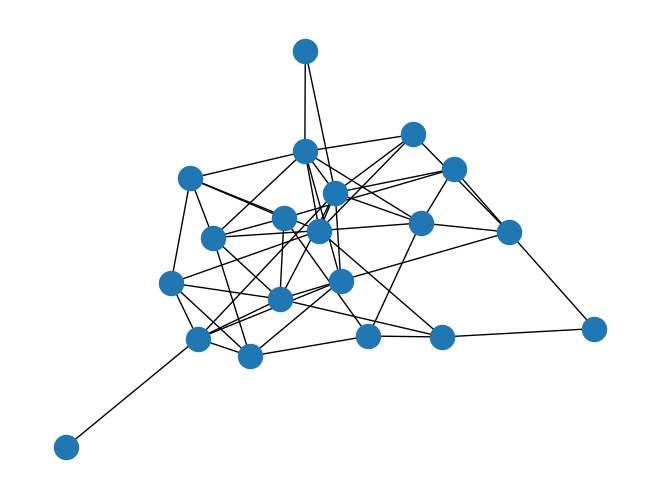

In [4]:
graph = erdos_renyi_graph(nodes, p_edge)
nx.draw(graph)
plt.show()

In [5]:
graph

We begin by trying to evaluate an approximation algorihtm using randomness. We will pick a node and assign it a color at random. Given a graph, it might be enough to randomly assign the colors, and then retry until we don't have any conflicts.

Before we try doing that though we create a function that determines if a function has conflicts, and some utils.

In [6]:
class Color(StrEnum):
    RED = "red"
    GREEN = "green"
    BLUE = "blue"

In [7]:
def cost_fun(graph, coloring) -> bool:
    """returns the number of edges were both nodes have the same colors"""
    cost = 0
    for (u, v) in graph.edges:
        if (u is None or v is None):
            # there exist a node without an edge
            # then that node will have a locally unique color
            continue

        u_color = coloring[u]
        v_color = coloring[v]

        if (u_color == v_color):
            # if both nodes have different colors
            cost += 1
    return cost
       

In [48]:
def score_fun(graph, coloring) -> bool:
    """returns the number of edges were both nodes have the same colors"""
    score = 0
    for (u, v) in graph.edges:
        if (u is None or v is None):
            # there exist a node without an edge
            # then that node will have a locally unique color
            score += 1
            continue

        u_color = coloring[u]
        v_color = coloring[v]

        if (u_color != v_color):
            # if both nodes have different colors
            score += 1
    return score
       

In [49]:
def gen_graph_and_partition(n_nodes: int, p_edge: float):
    graph = erdos_renyi_graph(n_nodes, p_edge)
    coloring = n_nodes * [Color.RED]
    return (graph, coloring)

## Initial test

In [50]:
n_nodes = 10
p_edge = 0.3
graph, coloring = gen_graph_and_partition(n_nodes, p_edge)

In [53]:
print(cost_fun(graph, coloring))
print(score_fun(graph, coloring))

9
0


## The algo

I'll test out an initial algorithm. Here I'll just generate a random coloring and then

In [11]:
def shuffle_coloring(coloring):
    coloring_copy = coloring.copy()
    colors = list(Color)
    for i in range(len(coloring)):
        coloring_copy[i] = random.choice(colors)
    return coloring_copy
    

In [43]:
def gen_best_coloring_using_cost(graph, coloring, max_iters = 500):
    best_coloring = coloring.copy()
    best_cost = cost_fun(graph, coloring)
    for i in range(max_iters):
        new_coloring = shuffle_coloring(coloring)
        new_cost = cost_fun(graph, new_coloring)
        if (new_cost == 0):
            return (new_coloring, new_cost)
        if (new_cost < best_cost):
            best_coloring = new_coloring
            best_cost = new_cost
    return best_coloring, best_cost, i
  

In [54]:
def gen_best_coloring_using_score(graph, coloring, max_iters = 500):
    best_coloring = coloring.copy()
    best_score = score_fun(graph, coloring)
    for i in range(max_iters):
        new_coloring = shuffle_coloring(coloring)
        new_score = score_fun(graph, new_coloring)
        if (new_score > best_score):
            best_coloring = new_coloring
            best_score = new_score
    return best_coloring, best_score
  

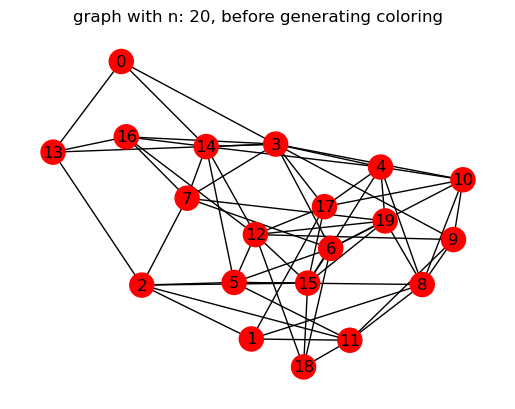

In [61]:
# before assigning color
n_nodes = 20
p_edge = 0.3
graph, coloring = gen_graph_and_partition(n_nodes, p_edge)
plt.title(f"graph with n: {n_nodes}, before generating coloring")
nx.draw(graph, node_color = coloring, with_labels=True)

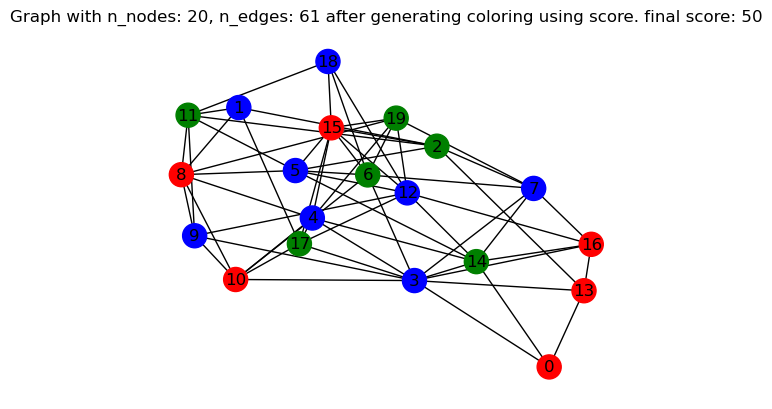

In [67]:
new_coloring, score = gen_best_coloring_using_score(graph, coloring)
n_edges = len(graph.edges)
plt.title(f"Graph with n_nodes: {n_nodes}, n_edges: {n_edges} after generating coloring using score. final score: {score}")
nx.draw(graph, node_color = new_coloring, with_labels=True)

Empirically we can see that more than two thirds of the edges are "satisfied". For these edges, it's ends have different colors.

# Math
how can we show this mathematically?

Given a graph $G = (v,e)$ and a coloring $C(v_i)$ we want a measure of how many edges are satisfied. We define the event $S_{e_i}$ to mean that the edge $i$ is satisfied ($S_{e_i} = 1$ meaning it is satisfied and $S_{e_i} = 0$ meaning it isn't ). We further define $S_i$ to mean that $i$ edges are satisfied. We are looking for $E[S_i]$ 

For a single edge $e_i$ we can compute $E[S_{e_i}] = P[S_{e_i} = 1]$

$$
P[S_{e_i} = 1] = \\
P[C(v_{e1}) \neq C(v_{e2})] = \\
\sum_{c_i \in \{R, G, B\}} P[C(v_{e1}) = c_i] P[C(v_{e2}) = C \setminus c_i] = \\
\sum_{c_i \in \{R, G, B\}} \dfrac{1}{3} \cdot \dfrac{2}{3} = \\
3 \cdot \dfrac{1}{3} \cdot \dfrac{2}{3} = \dfrac{2}{3}
$$

When we start counting more edges we cannot assume independent events, as one edge being satisfied will affect any other edges attached to its nodes.

$$
Pr[S_i] = Pr[S_{e_1}]
$$